# Classify architectural style

## Dataset creation

Instead of using an existing dataset, we are going to create our own.
We are creating a request to Wikimedia to download images of different architectural styles and we are saving each category into a separate folder.

We are using the CATEGORY variable to point to the Wikimedia page dedicated to each architectural style and download all the images contained into that page (e.g.: https://commons.wikimedia.org/wiki/Category:Arabic_architecture).

In this particular case, we used the following terms into the CATEGORY variable:

- Arabic_architecture
- Baroque_architecture
- Brutalist_architecture
- Colonial_architecture
- Gothic_architecture
- Modernist_architecture
- Postmodern_architecture

The dataset is going to be quite small. To create a reliable and robust model we're gonna need to find more images for each category.

A free dataset that could be used to integrate our own can be found here: https://www.kaggle.com/datasets/wwymak/architecture-dataset/data


We use this second dataset to add images to the existing folders and to add few more categories to our dataset:

- byzantine architecture
- art deco architecture
- beaux arts architecture
- palladian architecture

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mv /content/downloads /content/drive/MyDrive/DATI/img-architecture

In [ ]:
import os
import requests
import re

CATEGORY = "Neoclassical_architecture"
OUTPUT_FOLDER = "/content/drive/MyDrive/DATI/img-architecture/neoclassical"
API_URL = "https://commons.wikimedia.org/w/api.php"
USER_AGENT = "MyScript/1.0 (https://trnq.eu; s.trinchero@gmail.com)"

def sanitize_filename(filename):
    """
    Sanitize the filename to remove or replace invalid characters.
    """
    filename = re.sub(r'[\\/*?:"<>|]', "_", filename)  # Replace invalid characters with underscores. Be aware that this could lead to filenames like ____________.jpg
    filename = re.sub(r'%[0-9A-Fa-f]{2}', '_', filename)  # Replace URL-encoded characters
    return filename

def fetch_files(category):
    """
    Fetch file URLs from the specified Wikimedia Commons category.
    """
    params = {
        "action": "query",
        "format": "json",
        "list": "categorymembers",
        "cmtitle": f"Category:{category}",
        "cmtype": "file",
        "cmlimit": "max"
    }
    headers = {"User-Agent": USER_AGENT}
    files = []
    while True:
        response = requests.get(API_URL, params=params, headers=headers)
        response.raise_for_status()  # Ensure a successful request
        data = response.json()
        files.extend(data['query']['categorymembers'])

        if "continue" in data:
            params.update(data["continue"])
        else:
            break
    return files

def download_file(file_title, output_folder):
    """
    Download a file from Wikimedia Commons.
    """
    params = {
        "action": "query",
        "format": "json",
        "titles": file_title,
        "prop": "imageinfo",
        "iiprop": "url"
    }
    headers = {"User-Agent": USER_AGENT}
    response = requests.get(API_URL, params=params, headers=headers)
    response.raise_for_status()  # Ensure a successful request
    data = response.json()
    pages = data["query"]["pages"]
    for page_id, page in pages.items():
        if "imageinfo" in page:
            file_url = page["imageinfo"][0]["url"]
            file_name = sanitize_filename(file_url.split("/")[-1])
            file_path = os.path.join(output_folder, file_name)

            # Download the file
            print(f"Downloading {file_name}...")
            file_data = requests.get(file_url, headers=headers).content
            with open(file_path, "wb") as f:
                f.write(file_data)
                print(f"Downloaded: {file_name}")

def main():
    # Create output folder if not exists
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)

    # Fetch files from the category
    print("Fetching files from category...")
    files = fetch_files(CATEGORY)
    print(f"Found {len(files)} files. Starting download...")

    # Download each file
    for file in files:
        download_file(file["title"], OUTPUT_FOLDER)


main()


## Data cleaning


Some of the files we downloaded need to be converted into jpeg, because the original formats cannot be processed by our data loaders (e.g.: .gif) or the files are too big and the PIL library cannot handle them.

Also, be sure to inspect each folder visually to delete images that are not useful for training. Be sure to just keep into your dataset images of buildings.

In [ ]:
import os
import cv2

# Input and output paths
input_path = "/content/drive/MyDrive/DATI/img-architecture/train"
output_path = "/content/drive/MyDrive/DATI/img-architecture/train_converted"
os.makedirs(output_path, exist_ok=True)

for root, dirs, files in os.walk(input_path):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            # Load the image
            img = cv2.imread(file_path)
            if img is not None:
                # Save the image as JPEG
                new_file_name = os.path.splitext(file)[0] + ".jpg"
                save_dir = os.path.join(output_path, os.path.relpath(root, input_path))
                os.makedirs(save_dir, exist_ok=True)
                save_path = os.path.join(save_dir, new_file_name)
                cv2.imwrite(save_path, img, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
            else:
                print(f"Skipping unsupported or corrupted file: {file_path}")
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

## EDA - Exploratory data analysis

In [3]:
data_path = "/content/drive/MyDrive/DATI/img-architecture/train_converted"


We need to create a utility function to print an image galley and start exploring our dataset.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_image_gallery(images, titles=None, num_cols=3, figsize=(6, 12)):
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, squeeze=False)
    axes = axes.flatten()  # Flatten in case the axes is a 2D array

    for i, ax in enumerate(axes):
        if i < num_images:
            # Normalize each image
            img = np.asarray(images[i]) / 255.0
            img = np.minimum(np.maximum(img, 0.0), 1.0)

            # Plot the image
            ax.imshow(img)
            ax.axis("off")  # Remove axis
            if titles and len(titles) > i:
                ax.set_title(titles[i], fontsize=12)
        else:
            # Disable empty plots
            ax.axis("off")

    plt.show()
    plt.close()


We create a function to select nine random images and display name with the category label on top:

In [5]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img

def plot_random_images(directory, num_images=9, figsize=(12, 12)):
    #<Check if directory exists
    if not os.path.exists(directory):
        raise ValueError(f"The directory {directory} doesn't exists.")

    # Create lists of images and titles
    images = []
    titles = []

    for root, _, files in os.walk(directory):
        folder_name = os.path.basename(root)
        # Filters only images
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for file in image_files:
            images.append(os.path.join(root, file))
            titles.append(folder_name)

    if len(images) < num_images:
        raise ValueError("The aren't enough images to satisfy the request.")

    # Randomly selects images
    random_indices = random.sample(range(len(images)), num_images)
    selected_images = [images[i] for i in random_indices]
    selected_titles = [titles[i] for i in random_indices]

    # prepares images for visualization
    loaded_images = [np.array(load_img(img)) for img in selected_images]

    # Visualize images with plot_image_gallery
    plot_image_gallery(loaded_images, titles=selected_titles, num_cols=3, figsize=figsize)




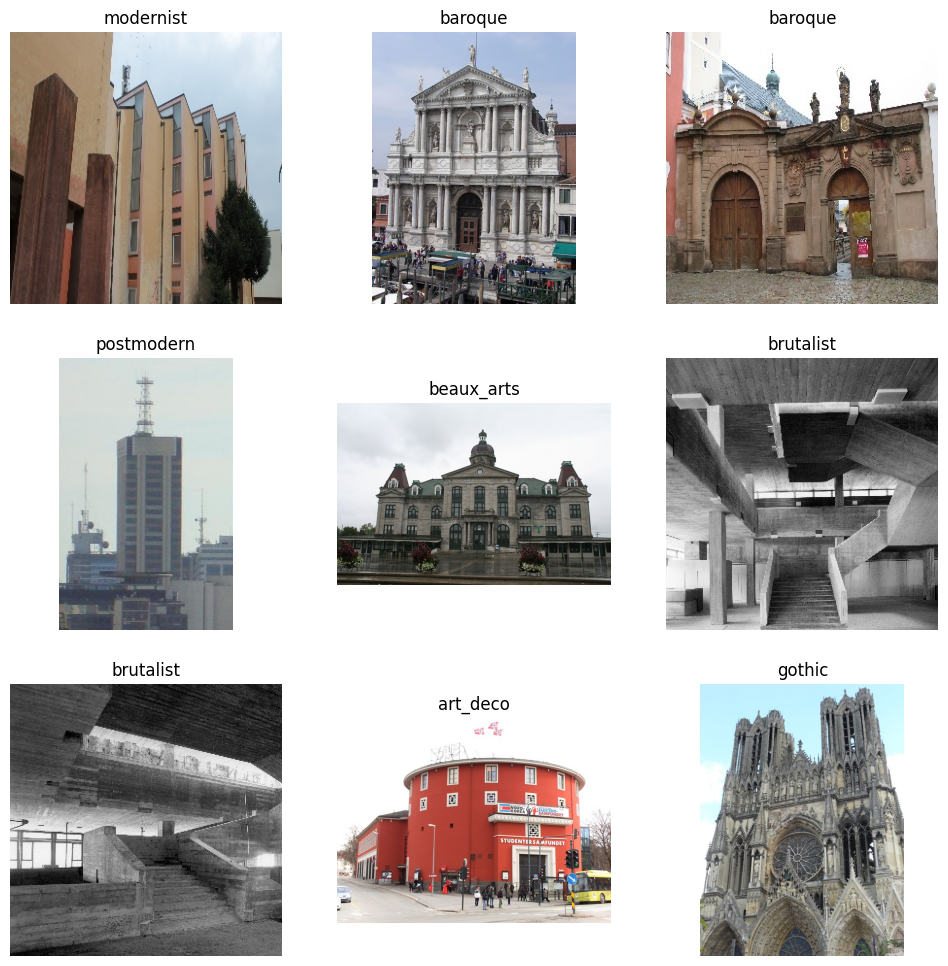

In [8]:
plot_random_images(data_path, num_images=9, figsize=(12, 12))

### Check files format

We write a function to check the file format of all our images:

In [9]:
import os
from collections import Counter

def extract_image_formats(directory):
    formats = Counter()
    for root, _, files in os.walk(directory):
        for file in files:
            if '.' in file:
                ext = os.path.splitext(file)[-1].lower()  # Get file extension
                formats[ext] += 1

    print(f"Total unique formats: {len(formats)}")
    print("\nImage Formats and Counts:")
    for fmt, count in formats.items():
        print(f"  {fmt}: {count} files")

    return formats



All our files are .jpg because we converted them before.

In [10]:
image_formats = extract_image_formats(data_path)


Total unique formats: 1

Image Formats and Counts:
  .jpg: 1738 files


### Directory structure analysis

We are going to analyze the folders structure to get an insight of the database:

- Count the number of subfolders / categories
- Count the number of images in each folder
- Check for class imbalance

In [27]:
import os
from collections import Counter

def analyze_directory_structure(directory):
  class_counts = Counter()
  for root, _, files in os.walk(directory):
    class_name = os.path.basename(root) # takes the name of the class from the name of the folder
    image_files = [f for f in files if f.lower().endswith('.jpg')] # all our images are .jpg, we exclude .txt files
    class_counts[class_name] += len(image_files)

  total_images = sum(class_counts.values())
  print(f"Total classes: {len(class_counts) - 1}")  # Exclude root folder
  print(f"Total images: {total_images}")
  print("\nClass Distribution:")
  for cls, count in class_counts.items():
      if cls:  # Skip root folder
          print(f"  {cls}: {count} images")

  return class_counts

In [28]:
class_counts = analyze_directory_structure(data_path)

Total classes: 11
Total images: 1775

Class Distribution:
  train_converted: 0 images
  colonial: 94 images
  baroque: 78 images
  brutalist: 154 images
  arabic: 45 images
  gothic: 164 images
  modernist: 308 images
  postmodern: 151 images
  byzantine: 111 images
  beaux_arts: 191 images
  art_deco: 366 images
  palladian: 113 images


Let's plot the class distribution:

In [ ]:
# Plot class distribution
def plot_class_distribution(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.title("Class Distribution")
    plt.xticks(rotation=45)
    plt.show()



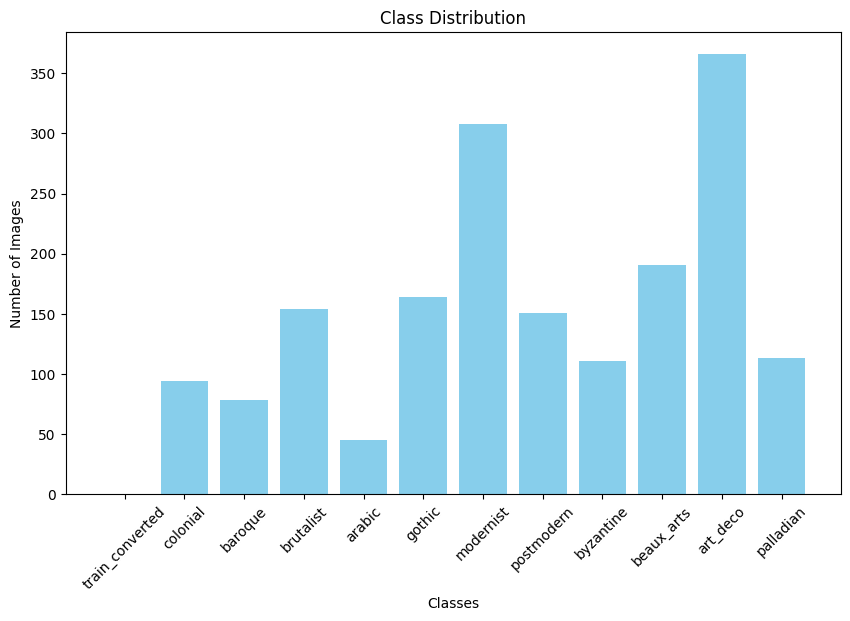

In [37]:
plot_class_distribution(class_counts)


In [31]:
from PIL import Image

def analyze_image_dimensions(directory):
    dimensions = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepath = os.path.join(root, file)
                with Image.open(filepath) as img:
                    dimensions.append(img.size)  # (width, height)

    # Analyze dimensions
    widths, heights = zip(*dimensions)
    print(f"Total Images: {len(dimensions)}")
    print(f"Average Width: {sum(widths)/len(widths):.2f}, Average Height: {sum(heights)/len(heights):.2f}")
    print(f"Max Width: {max(widths)}, Max Height: {max(heights)}")
    print(f"Min Width: {min(widths)}, Min Height: {min(heights)}")

    return dimensions

dimensions = analyze_image_dimensions(data_path)


Total Images: 1775
Average Width: 583.29, Average Height: 525.64
Max Width: 4288, Max Height: 4000
Min Width: 127, Min Height: 80


Let's create a list of the images that are too big, in order to resize them and speed up the data loading process:

In [33]:
import os
from PIL import Image


# Resize threshold dimensions
max_width = 2 * 583  # Example: Double the average width
max_height = 2 * 525  # Example: Double the average height

# List to store paths of images that are too big
big_images = []

def check_image_size(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
        if width > max_width or height > max_height:
            big_images.append((image_path, width, height))
            print(f"Too big: {image_path} ({width}x{height})")

for root, _, files in os.walk(data_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            image_path = os.path.join(root, file)
            check_image_size(image_path)

# Save the list of too big images to a file (optional)
output_file = "too_big_images.txt"
with open(output_file, "w") as f:
    for image_path, width, height in big_images:
        f.write(f"{image_path} ({width}x{height})\n")

print(f"\nFound {len(big_images)} oversized images. List saved to {output_file}.")


Too big: /content/drive/MyDrive/DATI/img-architecture/train_converted/gothic/Notre_Dame_Cathedral_-_Paris.jpg (1704x2272)
Too big: /content/drive/MyDrive/DATI/img-architecture/train_converted/gothic/Tours_Cathedral_Saint-Gatian_adj.jpg (2000x3008)
Too big: /content/drive/MyDrive/DATI/img-architecture/train_converted/gothic/Reims_Kathedrale.jpg (1536x2048)
Too big: /content/drive/MyDrive/DATI/img-architecture/train_converted/gothic/1280px-cathedral_of_exeter_edit.jpg (1280x978)
Too big: /content/drive/MyDrive/DATI/img-architecture/train_converted/gothic/Facade-notre-dame-paris-ciel-bleu.JPG (1637x2424)
Too big: /content/drive/MyDrive/DATI/img-architecture/train_converted/gothic/cathedrale_rouen_01.jpg (1024x1073)
Too big: /content/drive/MyDrive/DATI/img-architecture/train_converted/gothic/Expiatorio_GDL.jpg (2318x2327)
Too big: /content/drive/MyDrive/DATI/img-architecture/train_converted/gothic/Exeter-Cathedral.jpg (1600x1200)
Too big: /content/drive/MyDrive/DATI/img-architecture/train_

Now let's write a function to resize the oversized images:

In [35]:
from PIL import Image

# Path to the file containing list of oversized images
too_big_images_file = "too_big_images.txt"

# Target dimensions (average size)
max_width = 2 * 583  # Example: Double the average width
max_height = 2 * 525  # Example: Double the average height

def resize_image_in_place(image_path):
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            if width > max_width or height > max_height:
                # Calculate new dimensions while maintaining aspect ratio
                aspect_ratio = width / height
                if width > height:
                    new_width = max_width
                    new_height = int(max_width / aspect_ratio)
                else:
                    new_height = max_height
                    new_width = int(max_height * aspect_ratio)

                # Resize image
                img_resized = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
                img_resized.save(image_path)  # Save resized image in place
                print(f"Resized: {image_path} ({width}x{height} -> {new_width}x{new_height})")
            else:
                print(f"Skipped (already small): {image_path}")
    except Exception as e:
        print(f"Error resizing {image_path}: {e}")

# Read the list of oversized images from the file
with open(too_big_images_file, "r") as f:
    image_paths = [line.split(" (")[0].strip() for line in f.readlines()]

# Process each image
for image_path in image_paths:
    resize_image_in_place(image_path)


Resized: /content/drive/MyDrive/DATI/img-architecture/train_converted/gothic/Notre_Dame_Cathedral_-_Paris.jpg (1704x2272 -> 787x1050)
Resized: /content/drive/MyDrive/DATI/img-architecture/train_converted/gothic/Tours_Cathedral_Saint-Gatian_adj.jpg (2000x3008 -> 698x1050)
Resized: /content/drive/MyDrive/DATI/img-architecture/train_converted/gothic/Reims_Kathedrale.jpg (1536x2048 -> 787x1050)
Resized: /content/drive/MyDrive/DATI/img-architecture/train_converted/gothic/1280px-cathedral_of_exeter_edit.jpg (1280x978 -> 1166x890)
Resized: /content/drive/MyDrive/DATI/img-architecture/train_converted/gothic/Facade-notre-dame-paris-ciel-bleu.JPG (1637x2424 -> 709x1050)
Resized: /content/drive/MyDrive/DATI/img-architecture/train_converted/gothic/cathedrale_rouen_01.jpg (1024x1073 -> 1002x1050)
Resized: /content/drive/MyDrive/DATI/img-architecture/train_converted/gothic/Expiatorio_GDL.jpg (2318x2327 -> 1045x1050)
Resized: /content/drive/MyDrive/DATI/img-architecture/train_converted/gothic/Exeter-

## Training

### Data loading

Since our dataset is not organized in different subfolders for training and validation, we need to split our images usign Keras ImageDatagenerator.

We set the validation_split parameter to 0.2 to assign the 20 % of our dataset to the validation set.

With image_generator.flow_from_directory we generate a training and a validation dataset.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)

train_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory=data_path,
                                                 shuffle=True,
                                                 target_size=(150, 150),
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory=data_path,
                                                 shuffle=True,
                                                 target_size=(150, 150),
                                                 subset="validation",
                                                 class_mode='categorical')

Found 1395 images belonging to 11 classes.
Found 343 images belonging to 11 classes.


### Transfer learning

To train our model we start using a pretrained Xception model.

Let's create the base model:

In [12]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape = (150,150,3)
)

base_model.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
from tensorflow import keras


inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(11)(vectors) # The last layer will output 11 classes
model = keras.Model(inputs, outputs)

In [ ]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

We train the model for just one epoch, since we are going to optimize it later

In [43]:
history = model.fit(
    train_dataset,
    epochs=1,
    validation_data=validation_dataset
)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.3665 - loss: 3.2924 - val_accuracy: 0.4723 - val_loss: 2.7663


### Adjust the learning rate

In [15]:
def make_model(learning_rate = 0.01):
  base_model = Xception(
      weights = 'imagenet',
      include_top=False,
      input_shape=(150, 150, 3)
  )

  base_model.trainable = False

  inputs = keras.Input(shape=(150, 150, 3))
  base = base_model(inputs, training=False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)
  outputs = keras.layers.Dense(11)(vectors)
  model = keras.Model(inputs, outputs)

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=['accuracy']
  )

  return model



In [ ]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
  print(lr)
  model = make_model(learning_rate=lr)
  history = model.fit(train_dataset, epochs=10, validation_data = validation_dataset)
  scores[lr] = history.history

  print()
  print()

In [ ]:
for lr, hist in scores.items():
  plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

We go for a learning rate of 0.001

In [ ]:
learning_rate = 0.001


### Checkpointing

Let's create a chekpoint to save our best models during training, based on validation accuracy

Save the model weights:

In [16]:
model.save_weights('model_v1.weights.h5')


Create checkpoint:

In [17]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v3_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

We train for three epochs with a learning rate of 0.001

In [ ]:
learning_rate = 0.001

model = make_model(learning_rate=learning_rate)

history = model.fit(
    train_dataset,
    epochs=3,
    validation_data=validation_dataset,
    callbacks=[checkpoint]
)

### Adding more layers

We create a new make_model function with a parameter for the size of the inner layer.

In [49]:
def make_model(learning_rate=0.01, size_inner=100):
  base_model = Xception(
      weights='imagenet',
      include_top=False,
      input_shape=(150,150,3)
  )

  base_model.trainable=False

  inputs = keras.Input(shape=(150,150,3))
  base=base_model(inputs, training=False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)

  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
  outputs = keras.layers.Dense(11)(inner)
  model = keras.Model(inputs, outputs)

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=['accuracy']
  )

  return model

We find the best size for the inner layer.

In [ ]:
learning_rate = 0.001

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_dataset, epochs=3, validation_data=validation_dataset)
    scores[size] = history.history

    print()
    print()

### Regularization and dropout


Now we add regularization by freezing a part of the network.

We add a dropout value  to our model and we experiment with different values.

In [18]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(11)(drop)

    model = keras.Model(inputs, outputs)

    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [ ]:
learning_rate = 0.001
size = 100

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)
    scores[droprate] = history.history

    print()
    print()

In [ ]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.ylim(0.78, 0.86)
plt.legend()

In [ ]:
hist = scores[0.0]
plt.plot(hist['val_accuracy'], label=0.0)

hist = scores[0.2]
plt.plot(hist['val_accuracy'], label=0.2)

plt.legend()

### Data augmentation

Since our dataset is quiet small, we are going to need data augmentation in order to achieve better results.

Keras ImageDataGenerator provides different methods of data augmentation like:

- rotation
- shifts
- rescale
- flips

See: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

We use the preprocess_input function to augment our data.

We create new train and validation dataset with the new augmented image_generator.

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

image_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                     validation_split=0.2,
                                     rotation_range=30,
                                     width_shift_range=10,
                                     height_shift_range=10,
                                     shear_range=10,
                                     zoom_range=0.1,
                                     vertical_flip=False
                                     )

train_dataset = image_generator.flow_from_directory(batch_size=32,
                                                 directory=data_path,
                                                 shuffle=True,
                                                 target_size=(150, 150),
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=32,
                                                 directory=data_path,
                                                 shuffle=False,
                                                 target_size=(150, 150),
                                                 subset="validation",
                                                 class_mode='categorical')

Found 1395 images belonging to 11 classes.
Found 343 images belonging to 11 classes.


### Visualize augmented image

We are going to create a preview folder to store example of a random augmented image, to see how our augmentation strategy looks like.

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


img = load_img('/content/drive/MyDrive/DATI/img-architecture/train_converted/gothic/02_0004.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in image_generator.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='building', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

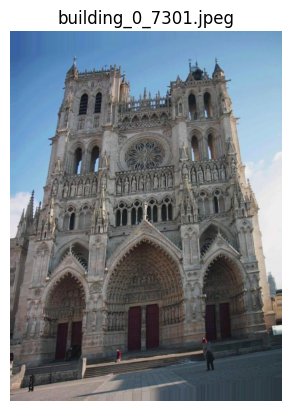

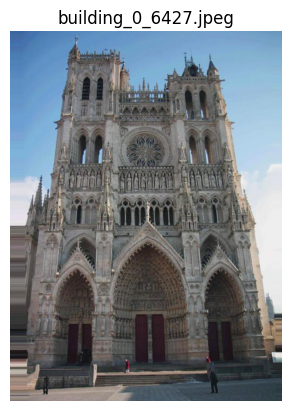

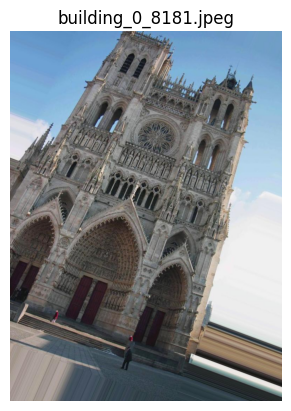

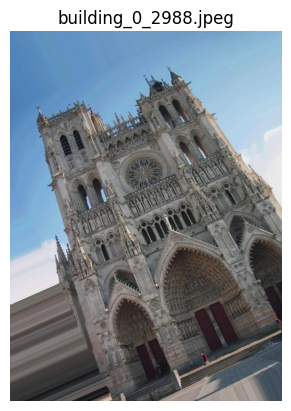

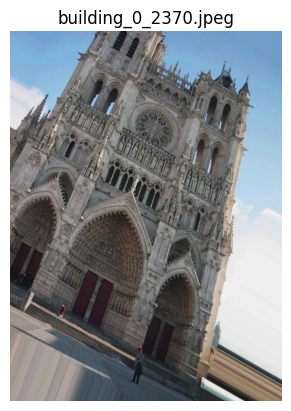

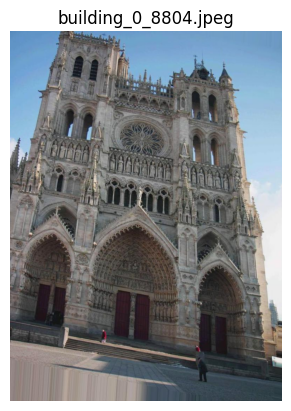

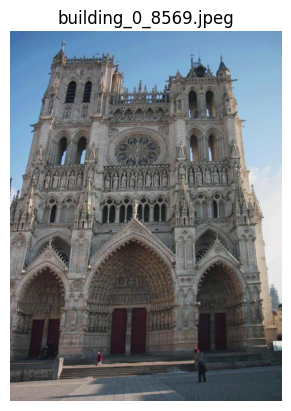

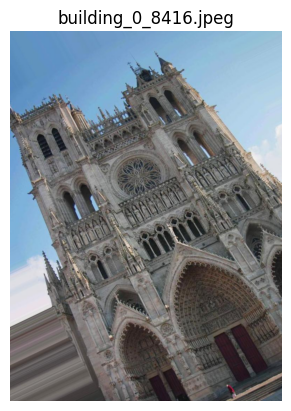

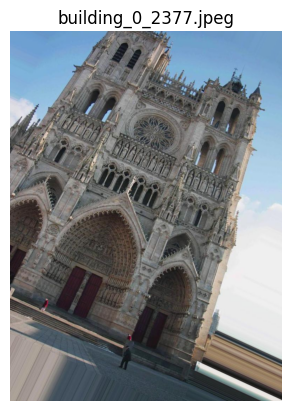

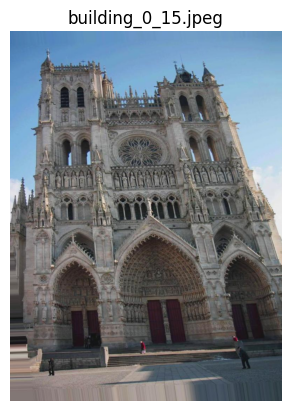

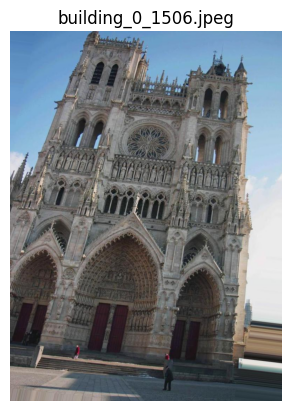

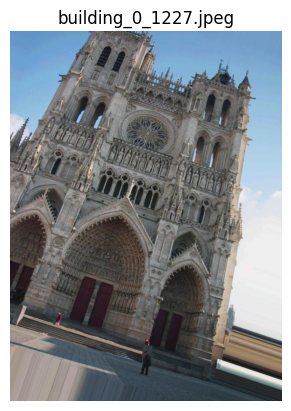

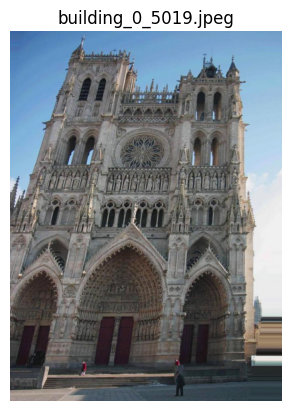

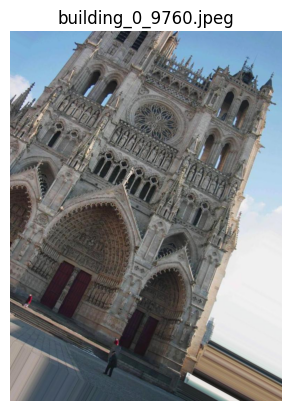

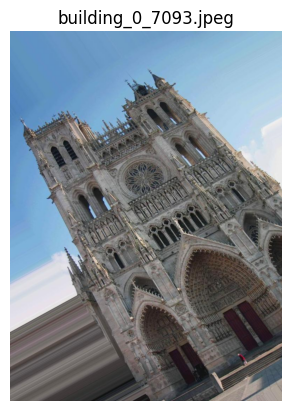

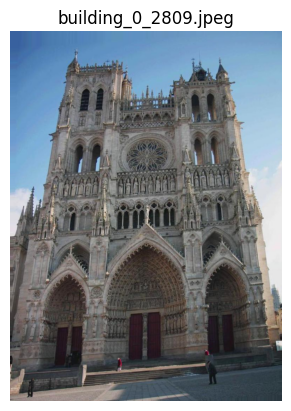

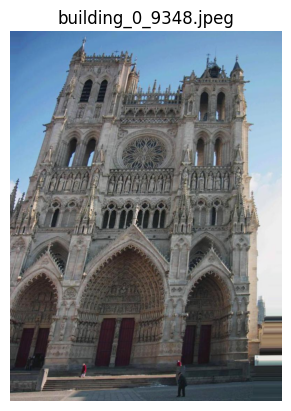

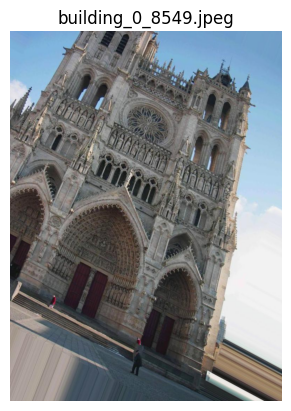

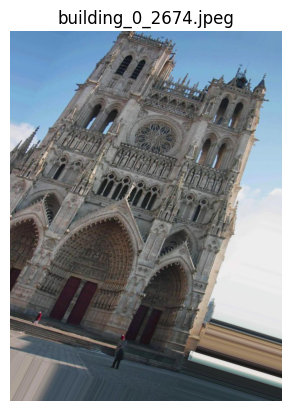

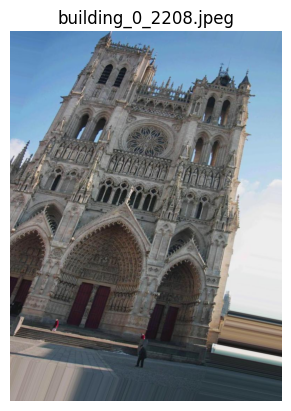

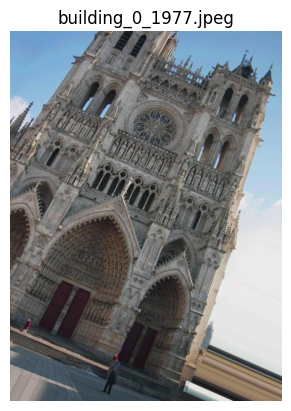

In [45]:
import os
import matplotlib.pyplot as plt
from PIL import Image

preview_folder_path = '/content/preview'

# List all files in the folder
image_files = [f for f in os.listdir(preview_folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]

# Display images
for image_file in image_files:
    image_path = os.path.join(preview_folder_path, image_file)
    img = Image.open(image_path)
    plt.figure()
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(image_file)  # Display file name as title
    plt.show()

### Train with the augmented dataset

In [21]:
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_dataset, epochs=15, validation_data=validation_dataset, callbacks=[checkpoint])

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 348s 7s/step - accuracy: 0.2704 - loss: 2.1676 - val_accuracy: 0.4752 - val_loss: 1.6091
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.4384 - loss: 1.6571 - val_accuracy: 0.5102 - val_loss: 1.4808
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 193s 4s/step - accuracy: 0.4921 - loss: 1.4936 - val_accuracy: 0.5773 - val_loss: 1.3024
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 188s 4s/step - accuracy: 0.5484 - loss: 1.3100 - val_accuracy: 0.5306 - val_loss: 1.3688
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 184s 4s/step - accuracy: 0.5661 - loss: 1.2713 - val_accuracy: 0.6064 - val_loss: 1.2851
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 181s 4s/step - accuracy: 0.5957 - loss: 1.1921 - val_accuracy: 0.5714 - val_loss: 1.2741
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.5977 - loss: 1.1597 - val_accuracy: 0.5627 - val_loss: 1.2800
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.6113 - loss: 1.0973 - val_accuracy: 0.5685 - val_loss: 1.

Let's plot the training results:

In [ ]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

## Train a larger model

Let's train a 299 x 299 model to see if the accuracy improves

In [47]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100,
               droprate=0.5):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(11)(drop)

    model = keras.Model(inputs, outputs)

    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [48]:
input_size = 299


In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

image_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                     validation_split=0.2,
                                     rotation_range=30,
                                     width_shift_range=10,
                                     height_shift_range=10,
                                     shear_range=10,
                                     zoom_range=0.1,
                                     vertical_flip=False
                                     )

train_dataset = image_generator.flow_from_directory(batch_size=32,
                                                 directory=data_path,
                                                 shuffle=True,
                                                 target_size=(input_size, input_size),
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=32,
                                                 directory=data_path,
                                                 shuffle=False,
                                                 target_size=(input_size, input_size),
                                                 subset="validation",
                                                 class_mode='categorical')

Found 1395 images belonging to 11 classes.
Found 343 images belonging to 11 classes.


In [50]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [51]:
learning_rate = 0.0005
size = 100
droprate = 0.2

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset,
                   callbacks=[checkpoint])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 820s 18s/step - accuracy: 0.2529 - loss: 2.1453 - val_accuracy: 0.5394 - val_loss: 1.5427
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 807s 18s/step - accuracy: 0.4805 - loss: 1.5316 - val_accuracy: 0.5948 - val_loss: 1.3016
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 791s 18s/step - accuracy: 0.5514 - loss: 1.3214 - val_accuracy: 0.6385 - val_loss: 1.1954
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 796s 18s/step - accuracy: 0.6111 - loss: 1.1549 - val_accuracy: 0.6210 - val_loss: 1.1736
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 846s 19s/step - accuracy: 0.6301 - loss: 1.0963 - val_accuracy: 0.6443 - val_loss: 1.0835
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 829s 18s/step - accuracy: 0.6684 - loss: 1.0156 - val_accuracy: 0.6122 - val_loss: 1.0705
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 810s 18s/step - accuracy: 0.6419 - loss: 1.0134 - val_accuracy: 0.6385 - val_loss: 1.0920
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 795s 18s/step - accuracy: 0.6777 - loss: 0.9637 - val_accuracy: 0.6531 - val_

KeyboardInterrupt: 

## Use the model for prediction

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import preprocess_input

Load and test our best model:

In [52]:
model = keras.models.load_model('/content/xception_v4_1_08_0.653.keras')
model.evaluate(validation_dataset)

11/11 ━━━━━━━━━━━━━━━━━━━━ 159s 14s/step - accuracy: 0.6783 - loss: 1.0211


[1.027990698814392, 0.6618075966835022]

Load an image for classification:

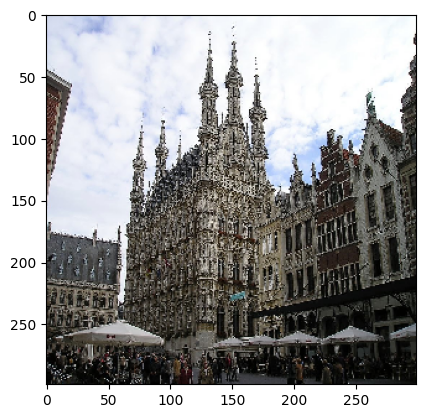

In [54]:
file_path = '/content/Leuven.jpg'
img = load_img(file_path, target_size=(299, 299))
plt.imshow(img)

In [55]:
import numpy as np
x = np.array(img)
X = np.array([x])
X.shape
X = preprocess_input(X)
pred = model.predict(X)
classes = list(train_dataset.class_indices.keys()) # extract the names of the classes and put them into a list
dict(zip(classes, pred[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


{'arabic': -0.6270199,
 'art_deco': -0.38102797,
 'baroque': 0.39663738,
 'beaux_arts': -0.08022516,
 'brutalist': -2.9979112,
 'byzantine': 1.2316139,
 'colonial': 0.572708,
 'gothic': 0.54111546,
 'modernist': -1.7924322,
 'palladian': -1.0330037,
 'postmodern': -2.930197}

## Save the model in Tensorflow Serving format


I converted the model to a Tensorflow Serving saved model, even if in the end I decided not to use TF Serving in my project because of version incompatibility issues with the library. 

In [1]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.load_model('/content/xception_v3_05_0.606.keras')

tf.saved_model.save(model, 'architecture-model')

Let's inspect the model:

In [2]:
!saved_model_cli show --dir architecture-model --all

2024-12-30 04:32:28.527947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-30 04:32:28.606934: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-30 04:32:28.637667: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-30 04:32:30.110201: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the followin